# Market Basket Analysis

Comprehensive market basket analysis project to discover product associations and patterns in retail transactions.

## Pipeline:
1. **Data Loading** - Load transaction data
2. **Data Cleaning** - Remove duplicates, fix product names, drop returns/cancellations, filter rare items, remove empty baskets
3. **Exploratory Data Analysis (EDA)** - Analyze most sold products, basket sizes, product pairs, categories, sales over time
4. **Transaction Encoding** - One-hot encoding for transactions
5. **Association Rule Mining** - Run Apriori/FP-Growth/Eclat algorithms
6. **Rule Generation & Filtering** - Generate and filter rules by lift, confidence, and support
7. **Validation** - Split data for testing
8. **Visualization** - Network graphs, heatmaps, rule tables, co-occurrence plots

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Association rule mining
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# Visualization
import networkx as nx
from itertools import combinations

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Libraries imported successfully!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the data
# Option 1: Load from CSV file (update the path to your CSV file location)
# df = pd.read_csv('OnlineRetailShopGermany.csv')

# Option 2: If you already have the data loaded in a variable, use it directly
# Just make sure your dataframe is named 'df' and has columns: InvoiceNo, Description, Quantity, etc.

# For this example, we'll try to load from CSV, but you can comment this out if using existing data

df = pd.read_csv('/content/drive/MyDrive/Market_basket_analysi/OnlineRetailShopGermany.csv')
print("Data loaded from CSV file successfully!")

# Display basic information
if 'df' in locals():
    print(f"\nDataset shape: {df.shape}")
    print(f"\nColumn names: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    df.head()

Data loaded from CSV file successfully!

Dataset shape: (9495, 8)

Column names: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First few rows:


In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536527,22809,SET OF 6 T-LIGHTS SANTA,6,12/1/2010 13:04,2.95,12662,Germany
1,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,12/1/2010 13:04,2.55,12662,Germany
2,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,12/1/2010 13:04,0.85,12662,Germany
3,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,12/1/2010 13:04,1.65,12662,Germany
4,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,12/1/2010 13:04,1.95,12662,Germany


In [8]:
# Data overview
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nDataset Statistics:")
print(df.describe())
print("\n" + "="*50)
print("\nMissing values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nData types:")
print(df.dtypes)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9495 entries, 0 to 9494
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    9495 non-null   object 
 1   StockCode    9495 non-null   object 
 2   Description  9495 non-null   object 
 3   Quantity     9495 non-null   int64  
 4   InvoiceDate  9495 non-null   object 
 5   UnitPrice    9495 non-null   float64
 6   CustomerID   9495 non-null   int64  
 7   Country      9495 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 593.6+ KB
None


Dataset Statistics:
          Quantity    UnitPrice    CustomerID
count  9495.000000  9495.000000   9495.000000
mean     12.369458     3.966930  12646.139336
std      17.865719    16.549026    309.138487
min    -288.000000     0.000000  12426.000000
25%       5.000000     1.250000  12480.000000
50%      10.000000     1.950000  12592.000000
75%      12.000000     3.750000  12662.000000
m

## 2. Data Cleaning

**Very important steps:**
- ✅ Remove duplicates
- ✅ Fix product names
- ✅ Drop returns/cancellations
- ✅ Filter rare items
- ✅ Remove empty baskets

In [9]:
# Create a copy for cleaning
df_clean = df.copy()

print(f"Original shape: {df_clean.shape}")

# 1. Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")

# 2. Fix product names (remove extra spaces, standardize)
if 'Description' in df_clean.columns:
    df_clean['Description'] = df_clean['Description'].str.strip()
    df_clean['Description'] = df_clean['Description'].str.upper()
    # Remove multiple spaces
    df_clean['Description'] = df_clean['Description'].str.replace(r'\s+', ' ', regex=True)

# 3. Drop returns/cancellations (negative quantities or invoice numbers starting with 'C' or 'R')
if 'Quantity' in df_clean.columns:
    df_clean = df_clean[df_clean['Quantity'] > 0]
    print(f"After removing negative quantities: {df_clean.shape}")

if 'InvoiceNo' in df_clean.columns:
    # Remove cancelled invoices (usually start with 'C')
    df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C', na=False)]
    print(f"After removing cancellations: {df_clean.shape}")

# 4. Remove rows with missing product descriptions
if 'Description' in df_clean.columns:
    df_clean = df_clean[df_clean['Description'].notna()]
    df_clean = df_clean[df_clean['Description'] != '']
    print(f"After removing empty descriptions: {df_clean.shape}")

# 5. Filter rare items (products that appear in less than X transactions)
# This helps reduce noise and focus on meaningful associations
if 'Description' in df_clean.columns:
    product_counts = df_clean['Description'].value_counts()
    min_transactions = 10  # Minimum number of transactions for a product to be included
    frequent_products = product_counts[product_counts >= min_transactions].index
    df_clean = df_clean[df_clean['Description'].isin(frequent_products)]
    print(f"After filtering rare items (min {min_transactions} transactions): {df_clean.shape}")

# 6. Remove empty baskets (invoices with no products after cleaning)
if 'InvoiceNo' in df_clean.columns:
    basket_sizes = df_clean.groupby('InvoiceNo').size()
    non_empty_baskets = basket_sizes[basket_sizes > 0].index
    df_clean = df_clean[df_clean['InvoiceNo'].isin(non_empty_baskets)]
    print(f"After removing empty baskets: {df_clean.shape}")

print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
df_clean.head()

Original shape: (9495, 8)
After removing duplicates: (9480, 8)
After removing negative quantities: (9027, 8)
After removing cancellations: (9027, 8)
After removing empty descriptions: (9027, 8)
After filtering rare items (min 10 transactions): (5012, 8)
After removing empty baskets: (5012, 8)

Final cleaned dataset shape: (5012, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,12/1/2010 13:04,1.95,12662,Germany
5,536527,22243,5 HOOK HANGER RED MAGIC TOADSTOOL,12,12/1/2010 13:04,1.65,12662,Germany
7,536527,20712,JUMBO BAG WOODLAND ANIMALS,10,12/1/2010 13:04,1.95,12662,Germany
8,536527,20713,JUMBO BAG OWLS,10,12/1/2010 13:04,1.95,12662,Germany
11,536527,22973,CHILDREN'S CIRCUS PARADE MUG,12,12/1/2010 13:04,1.65,12662,Germany


## 3. Exploratory Data Analysis (EDA)

Before modeling, let's explore:
- Most sold products
- Basket size distribution
- Top product pairs
- Frequent categories
- Sales over time

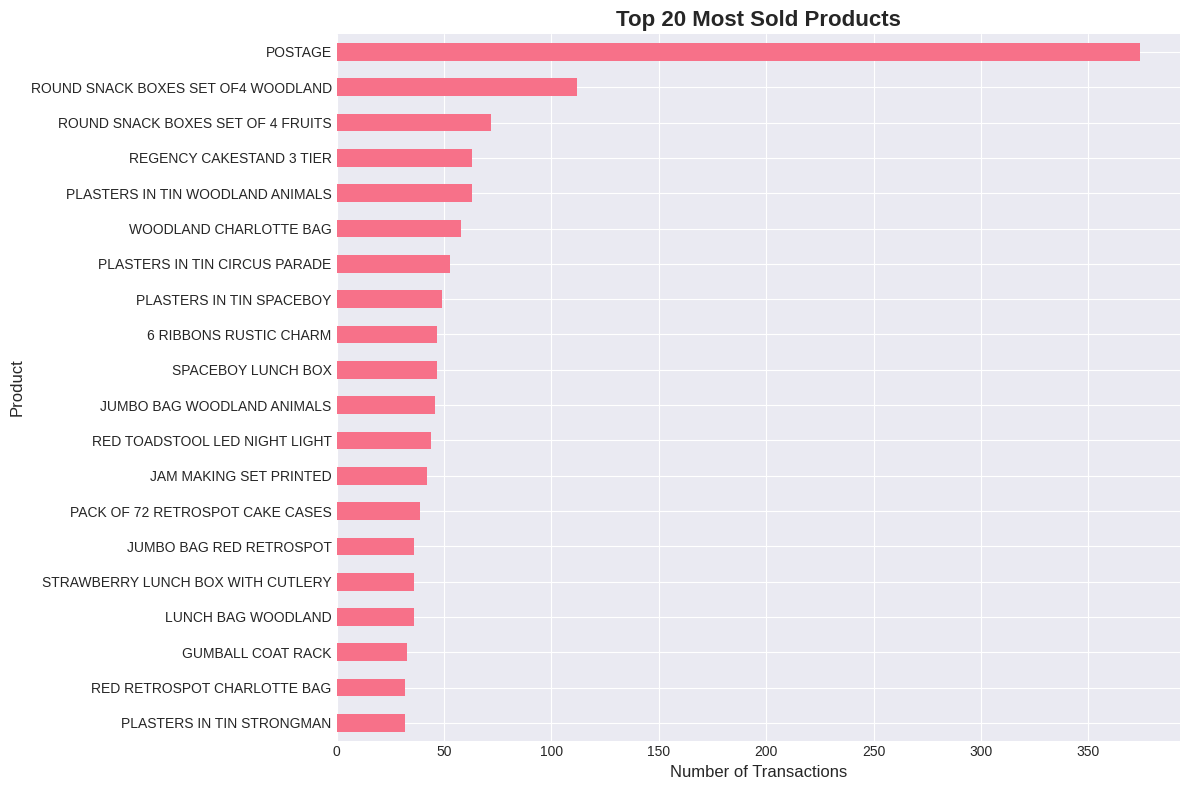

Top 10 Most Sold Products:
Description
POSTAGE                               374
ROUND SNACK BOXES SET OF4 WOODLAND    112
ROUND SNACK BOXES SET OF 4 FRUITS      72
REGENCY CAKESTAND 3 TIER               63
PLASTERS IN TIN WOODLAND ANIMALS       63
WOODLAND CHARLOTTE BAG                 58
PLASTERS IN TIN CIRCUS PARADE          53
PLASTERS IN TIN SPACEBOY               49
6 RIBBONS RUSTIC CHARM                 47
SPACEBOY LUNCH BOX                     47
Name: count, dtype: int64


In [10]:
# Most sold products
if 'Description' in df_clean.columns:
    top_products = df_clean['Description'].value_counts().head(20)

    plt.figure(figsize=(12, 8))
    top_products.plot(kind='barh')
    plt.title('Top 20 Most Sold Products', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Transactions', fontsize=12)
    plt.ylabel('Product', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Sold Products:")
    print(top_products.head(10))

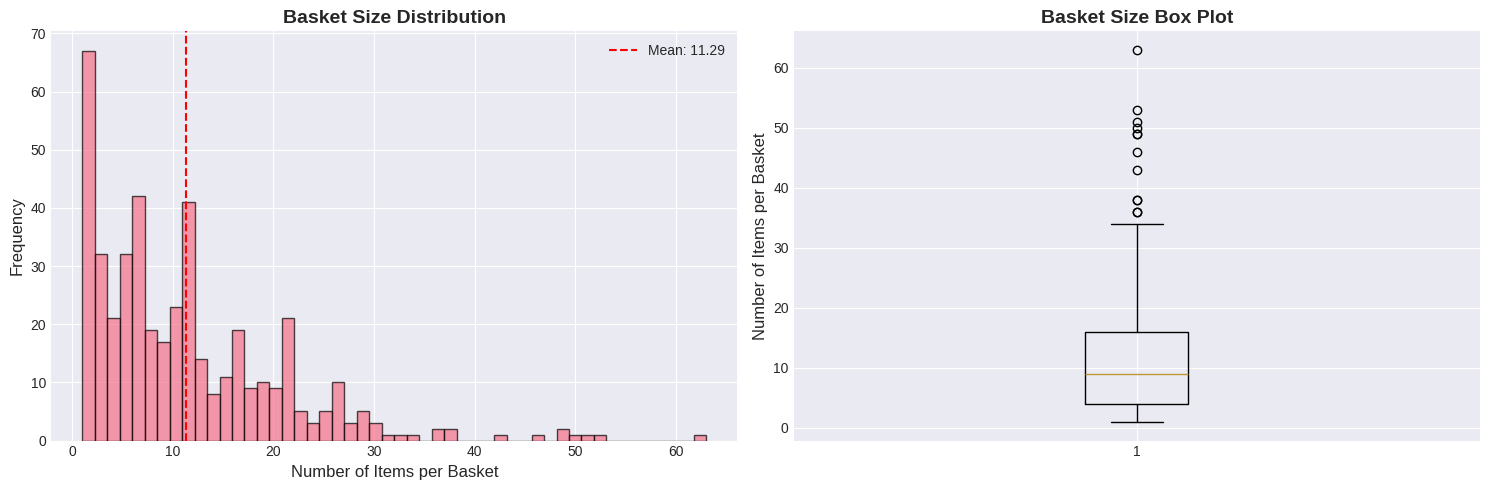


Basket Size Statistics:
Mean: 11.29
Median: 9.00
Min: 1
Max: 63
Std: 9.68


In [11]:
# Basket size distribution
if 'InvoiceNo' in df_clean.columns:
    basket_sizes = df_clean.groupby('InvoiceNo').size()

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Histogram
    axes[0].hist(basket_sizes, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title('Basket Size Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Number of Items per Basket', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].axvline(basket_sizes.mean(), color='red', linestyle='--',
                     label=f'Mean: {basket_sizes.mean():.2f}')
    axes[0].legend()

    # Box plot
    axes[1].boxplot(basket_sizes, vert=True)
    axes[1].set_title('Basket Size Box Plot', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Number of Items per Basket', fontsize=12)

    plt.tight_layout()
    plt.show()

    print(f"\nBasket Size Statistics:")
    print(f"Mean: {basket_sizes.mean():.2f}")
    print(f"Median: {basket_sizes.median():.2f}")
    print(f"Min: {basket_sizes.min()}")
    print(f"Max: {basket_sizes.max()}")
    print(f"Std: {basket_sizes.std():.2f}")

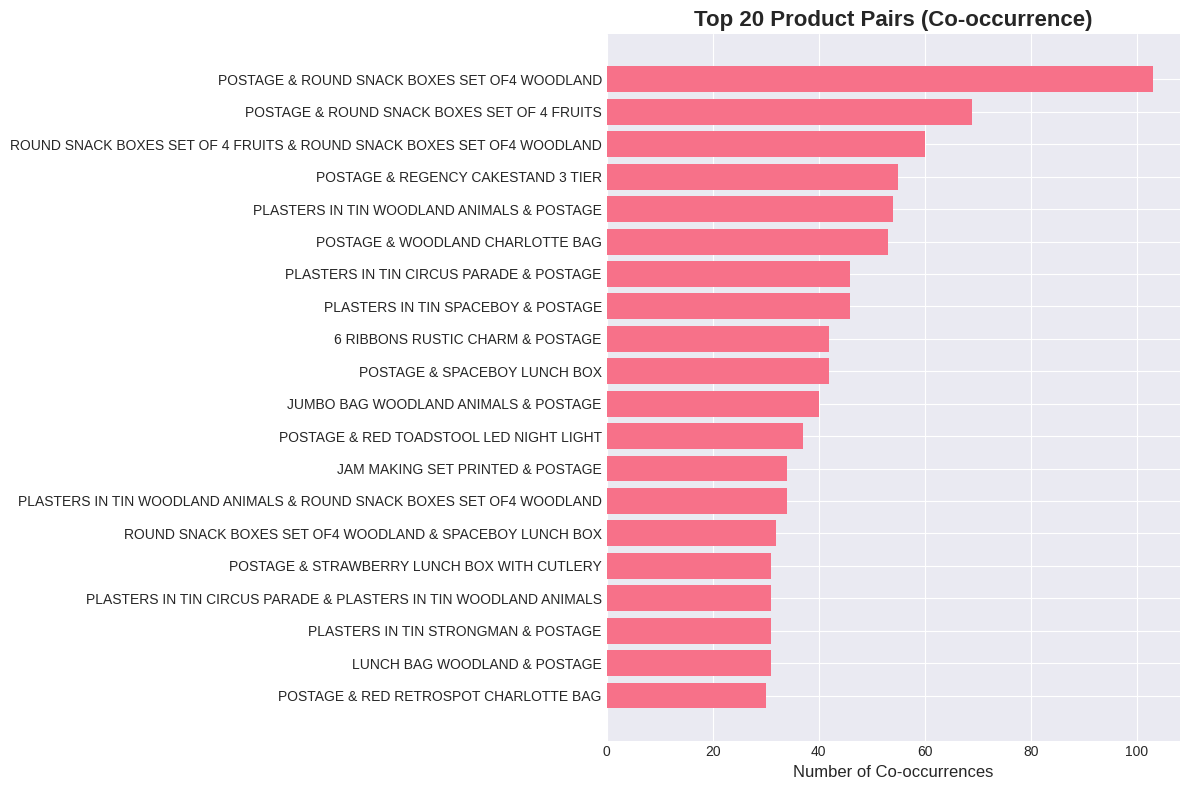

Top 10 Product Pairs:
1. POSTAGE & ROUND SNACK BOXES SET OF4 WOODLAND: 103 times
2. POSTAGE & ROUND SNACK BOXES SET OF 4 FRUITS: 69 times
3. ROUND SNACK BOXES SET OF 4 FRUITS & ROUND SNACK BOXES SET OF4 WOODLAND: 60 times
4. POSTAGE & REGENCY CAKESTAND 3 TIER: 55 times
5. PLASTERS IN TIN WOODLAND ANIMALS & POSTAGE: 54 times
6. POSTAGE & WOODLAND CHARLOTTE BAG: 53 times
7. PLASTERS IN TIN CIRCUS PARADE & POSTAGE: 46 times
8. PLASTERS IN TIN SPACEBOY & POSTAGE: 46 times
9. 6 RIBBONS RUSTIC CHARM & POSTAGE: 42 times
10. POSTAGE & SPACEBOY LUNCH BOX: 42 times


In [12]:
# Top product pairs (co-occurrence)
if 'InvoiceNo' in df_clean.columns and 'Description' in df_clean.columns:
    # Create transaction list
    transactions = df_clean.groupby('InvoiceNo')['Description'].apply(list).tolist()

    # Count product pairs
    pair_counts = {}
    for transaction in transactions:
        if len(transaction) > 1:
            for pair in combinations(sorted(transaction), 2):
                pair_counts[pair] = pair_counts.get(pair, 0) + 1

    # Get top pairs
    top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:20]

    # Create visualization
    pairs_df = pd.DataFrame(top_pairs, columns=['Pair', 'Count'])
    pairs_df['Pair_Str'] = pairs_df['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(pairs_df)), pairs_df['Count'])
    plt.yticks(range(len(pairs_df)), pairs_df['Pair_Str'])
    plt.title('Top 20 Product Pairs (Co-occurrence)', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Co-occurrences', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 10 Product Pairs:")
    for i, (pair, count) in enumerate(top_pairs[:10], 1):
        print(f"{i}. {pair[0]} & {pair[1]}: {count} times")

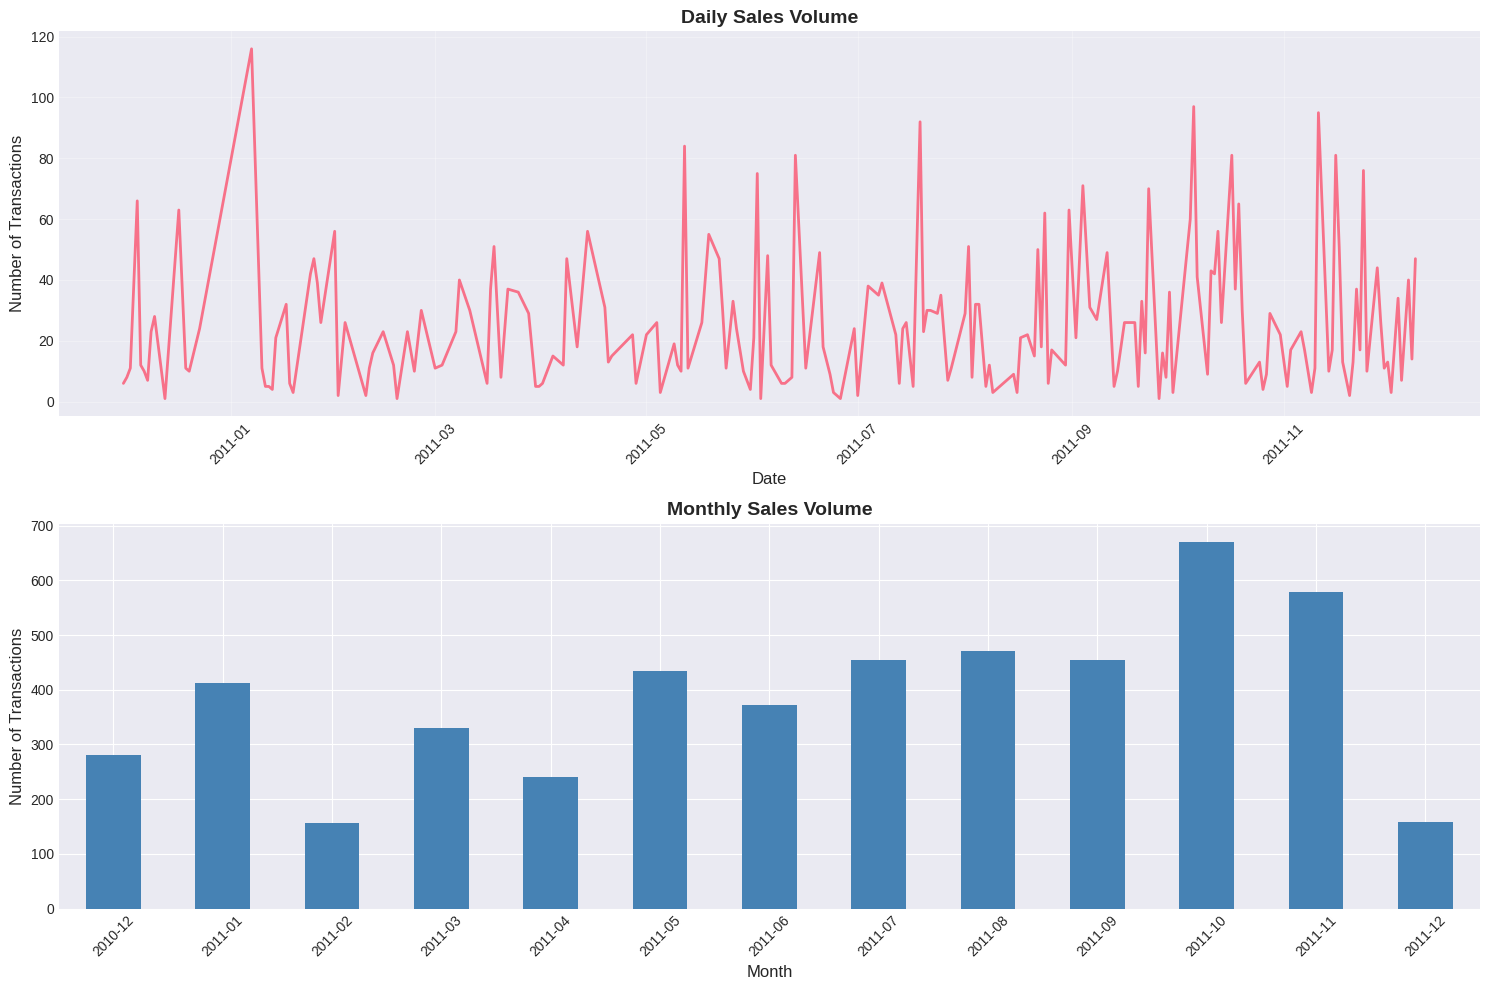


Sales Period: 2010-12-01 to 2011-12-09
Total days: 373

Average daily transactions: 25.19


In [13]:
# Sales over time (if InvoiceDate column exists)
if 'InvoiceDate' in df_clean.columns:
    # Convert to datetime
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
    df_clean = df_clean[df_clean['InvoiceDate'].notna()]

    # Create date columns
    df_clean['Date'] = df_clean['InvoiceDate'].dt.date
    df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')

    # Daily sales
    daily_sales = df_clean.groupby('Date').size()

    # Monthly sales
    monthly_sales = df_clean.groupby('Month').size()

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Daily sales
    axes[0].plot(daily_sales.index, daily_sales.values, linewidth=2)
    axes[0].set_title('Daily Sales Volume', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Number of Transactions', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # Monthly sales
    monthly_sales.plot(kind='bar', ax=axes[1], color='steelblue')
    axes[1].set_title('Monthly Sales Volume', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].set_ylabel('Number of Transactions', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"\nSales Period: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
    print(f"Total days: {(df_clean['Date'].max() - df_clean['Date'].min()).days}")
    print(f"\nAverage daily transactions: {daily_sales.mean():.2f}")

## 4. Transaction Encoding

Convert transactions to one-hot encoded format for association rule mining.

In [14]:
# Prepare transaction data
if 'InvoiceNo' in df_clean.columns and 'Description' in df_clean.columns:
    # Group by invoice and get list of products
    transactions = df_clean.groupby('InvoiceNo')['Description'].apply(list).tolist()

    print(f"Total number of transactions: {len(transactions)}")
    print(f"Sample transaction: {transactions[0]}")

    # One-hot encoding using TransactionEncoder
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    print(f"\nEncoded dataset shape: {df_encoded.shape}")
    print(f"Number of unique products: {len(te.columns_)}")
    print(f"\nFirst few rows of encoded data:")
    df_encoded.head()

Total number of transactions: 444
Sample transaction: ['3 HOOK HANGER MAGIC GARDEN', '5 HOOK HANGER RED MAGIC TOADSTOOL', 'JUMBO BAG WOODLAND ANIMALS', 'JUMBO BAG OWLS', "CHILDREN'S CIRCUS PARADE MUG", 'POSTAGE']

Encoded dataset shape: (444, 255)
Number of unique products: 255

First few rows of encoded data:


In [15]:
## 1. Load Data

#Load your transaction data. Update the path to your CSV file.

In [16]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

# Split transactions (80% train, 20% test)
train_transactions, test_transactions = train_test_split(
    transactions, test_size=0.2, random_state=42
)

# Encode train and test separately
te_train = TransactionEncoder()
te_train_ary = te_train.fit(train_transactions).transform(train_transactions)
df_train = pd.DataFrame(te_train_ary, columns=te_train.columns_)

te_test = TransactionEncoder()
te_test_ary = te_test.fit(test_transactions).transform(test_transactions)
df_test = pd.DataFrame(te_test_ary, columns=te_test.columns_)

# Align test columns with train columns (only keep products seen in training)
df_test = df_test.reindex(columns=te_train.columns_, fill_value=False)

print(f"Training set: {df_train.shape[0]} transactions, {df_train.shape[1]} products")
print(f"Test set: {df_test.shape[0]} transactions, {df_test.shape[1]} products")
print(f"\nUsing training set for association rule mining...")

# Use training set for modeling
df_encoded = df_train.copy()

Training set: 355 transactions, 255 products
Test set: 89 transactions, 255 products

Using training set for association rule mining...


In [17]:
# Set parameters
min_support = 0.01  # Minimum support (1% of transactions)
min_confidence = 0.3  # Minimum confidence (30%)
min_lift = 1.0  # Minimum lift (lift > 1 means positive association)

print(f"Parameters:")
print(f"  Min Support: {min_support}")
print(f"  Min Confidence: {min_confidence}")
print(f"  Min Lift: {min_lift}")

Parameters:
  Min Support: 0.01
  Min Confidence: 0.3
  Min Lift: 1.0


In [18]:
# Method 2: FP-Growth Algorithm (Faster for large datasets)
print("Running FP-Growth algorithm...")
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
print(f"Found {len(frequent_itemsets_fpgrowth)} frequent itemsets")

# Generate association rules
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=min_confidence)
print(f"Generated {len(rules_fpgrowth)} association rules")

# Filter by lift
rules_fpgrowth = rules_fpgrowth[rules_fpgrowth['lift'] >= min_lift]
print(f"After filtering by lift >= {min_lift}: {len(rules_fpgrowth)} rules")

rules_fpgrowth.head(10)

Running FP-Growth algorithm...
Found 8261 frequent itemsets
Generated 54189 association rules
After filtering by lift >= 1.0: 53554 rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(CHILDS BREAKFAST SET CIRCUS PARADE),(POSTAGE),0.047887,0.842254,0.042254,0.882353,1.047610,1.0,0.001920,1.340845,0.047732,0.049834,0.254202,0.466260
1,(CHILDS BREAKFAST SET CIRCUS PARADE),(ROUND SNACK BOXES SET OF 4 FRUITS),0.047887,0.160563,0.025352,0.529412,3.297214,1.0,0.017663,1.783803,0.731755,0.138462,0.439400,0.343653
2,(CHILDS BREAKFAST SET CIRCUS PARADE),(ROUND SNACK BOXES SET OF4 WOODLAND),0.047887,0.236620,0.022535,0.470588,1.988796,1.0,0.011204,1.441941,0.522189,0.086022,0.306490,0.282913
3,"(CHILDS BREAKFAST SET CIRCUS PARADE, POSTAGE)",(ROUND SNACK BOXES SET OF 4 FRUITS),0.042254,0.160563,0.025352,0.600000,3.736842,1.0,0.018568,2.098592,0.764706,0.142857,0.523490,0.378947
4,"(CHILDS BREAKFAST SET CIRCUS PARADE, ROUND SNA...",(POSTAGE),0.025352,0.842254,0.025352,1.000000,1.187291,1.0,0.003999,inf,0.161850,0.030100,1.000000,0.515050
5,(CHILDS BREAKFAST SET CIRCUS PARADE),"(ROUND SNACK BOXES SET OF 4 FRUITS, POSTAGE)",0.047887,0.154930,0.025352,0.529412,3.417112,1.0,0.017933,1.795775,0.742932,0.142857,0.443137,0.346524
6,"(CHILDS BREAKFAST SET CIRCUS PARADE, ROUND SNA...",(POSTAGE),0.022535,0.842254,0.022535,1.000000,1.187291,1.0,0.003555,inf,0.161383,0.026756,1.000000,0.513378
7,"(CHILDS BREAKFAST SET CIRCUS PARADE, POSTAGE)",(ROUND SNACK BOXES SET OF4 WOODLAND),0.042254,0.236620,0.022535,0.533333,2.253968,1.0,0.012537,1.635815,0.580882,0.087912,0.388684,0.314286
8,(CHILDS BREAKFAST SET CIRCUS PARADE),"(ROUND SNACK BOXES SET OF4 WOODLAND, POSTAGE)",0.047887,0.219718,0.022535,0.470588,2.141780,1.0,0.012013,1.473865,0.559911,0.091954,0.321512,0.286576
9,"(CHILDS BREAKFAST SET CIRCUS PARADE, ROUND SNA...",(ROUND SNACK BOXES SET OF 4 FRUITS),0.022535,0.160563,0.019718,0.875000,5.449561,1.0,0.016100,6.715493,0.835323,0.120690,0.851091,0.498904


## 7. Filter & Rank Rules

Business-focused filtering:
- **Lift > 1**: Positive association
- **High confidence**: Reliable predictions
- **Reasonable support**: Rules based on sufficient data

## 8. Visualization

Create visualizations:
- Network graphs of products
- Heatmaps
- Rule tables
- Item co-occurrence plots

In [24]:
business_rules = rules_fpgrowth.copy()

# Assigning aliases to resolve NameError in subsequent summary cell
frequent_itemsets = frequent_itemsets_fpgrowth
rules = rules_fpgrowth

# optional: sort so the "best" rules come first
business_rules = business_rules.sort_values(
    by=["lift", "confidence", "support"],
    ascending=False
).reset_index(drop=True)

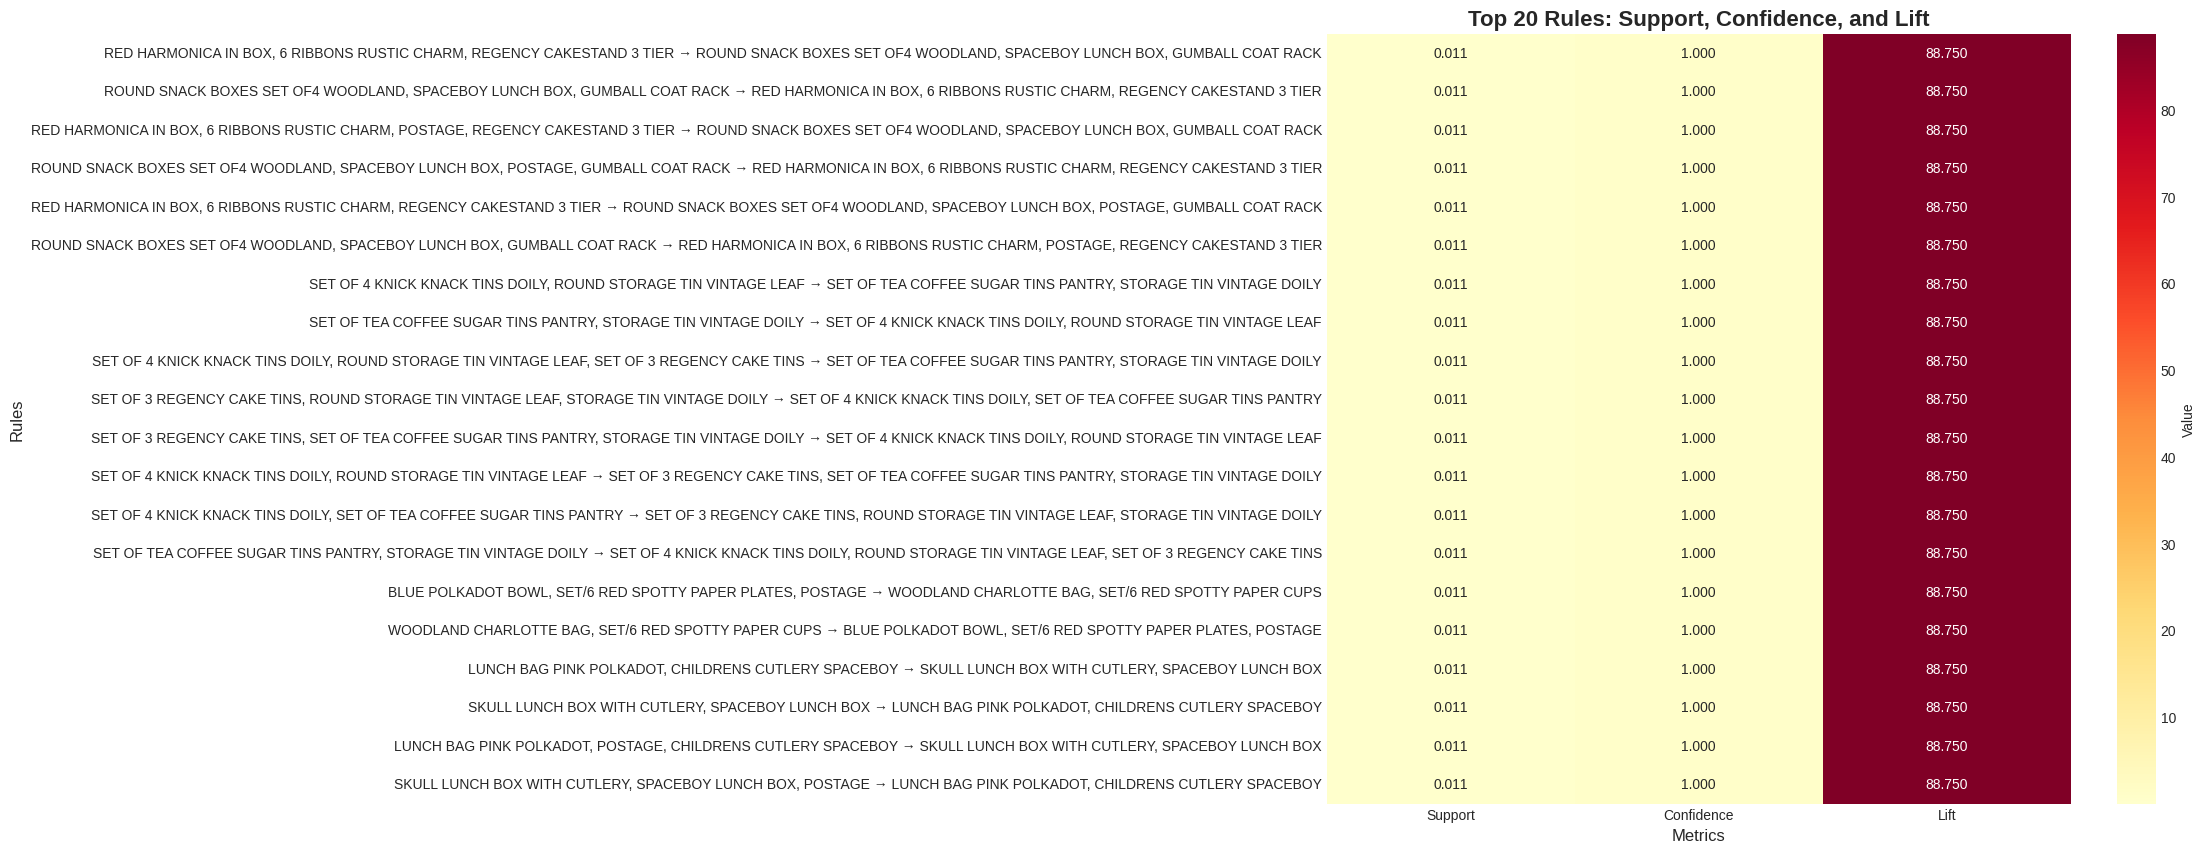

In [20]:
# 2. Heatmap of Support, Confidence, and Lift
if len(business_rules) > 0:
    # Prepare data for heatmap (top 20 rules)
    top_20_rules = business_rules.head(20).copy()
    top_20_rules['rule_str'] = top_20_rules.apply(
        lambda x: f"{', '.join(list(x['antecedents']))} → {', '.join(list(x['consequents']))}",
        axis=1
    )

    # Create heatmap data
    heatmap_data = top_20_rules[['support', 'confidence', 'lift']].values

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data,
                yticklabels=top_20_rules['rule_str'],
                xticklabels=['Support', 'Confidence', 'Lift'],
                annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Value'})
    plt.title('Top 20 Rules: Support, Confidence, and Lift', fontsize=16, fontweight='bold')
    plt.ylabel('Rules', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.tight_layout()
    plt.show()

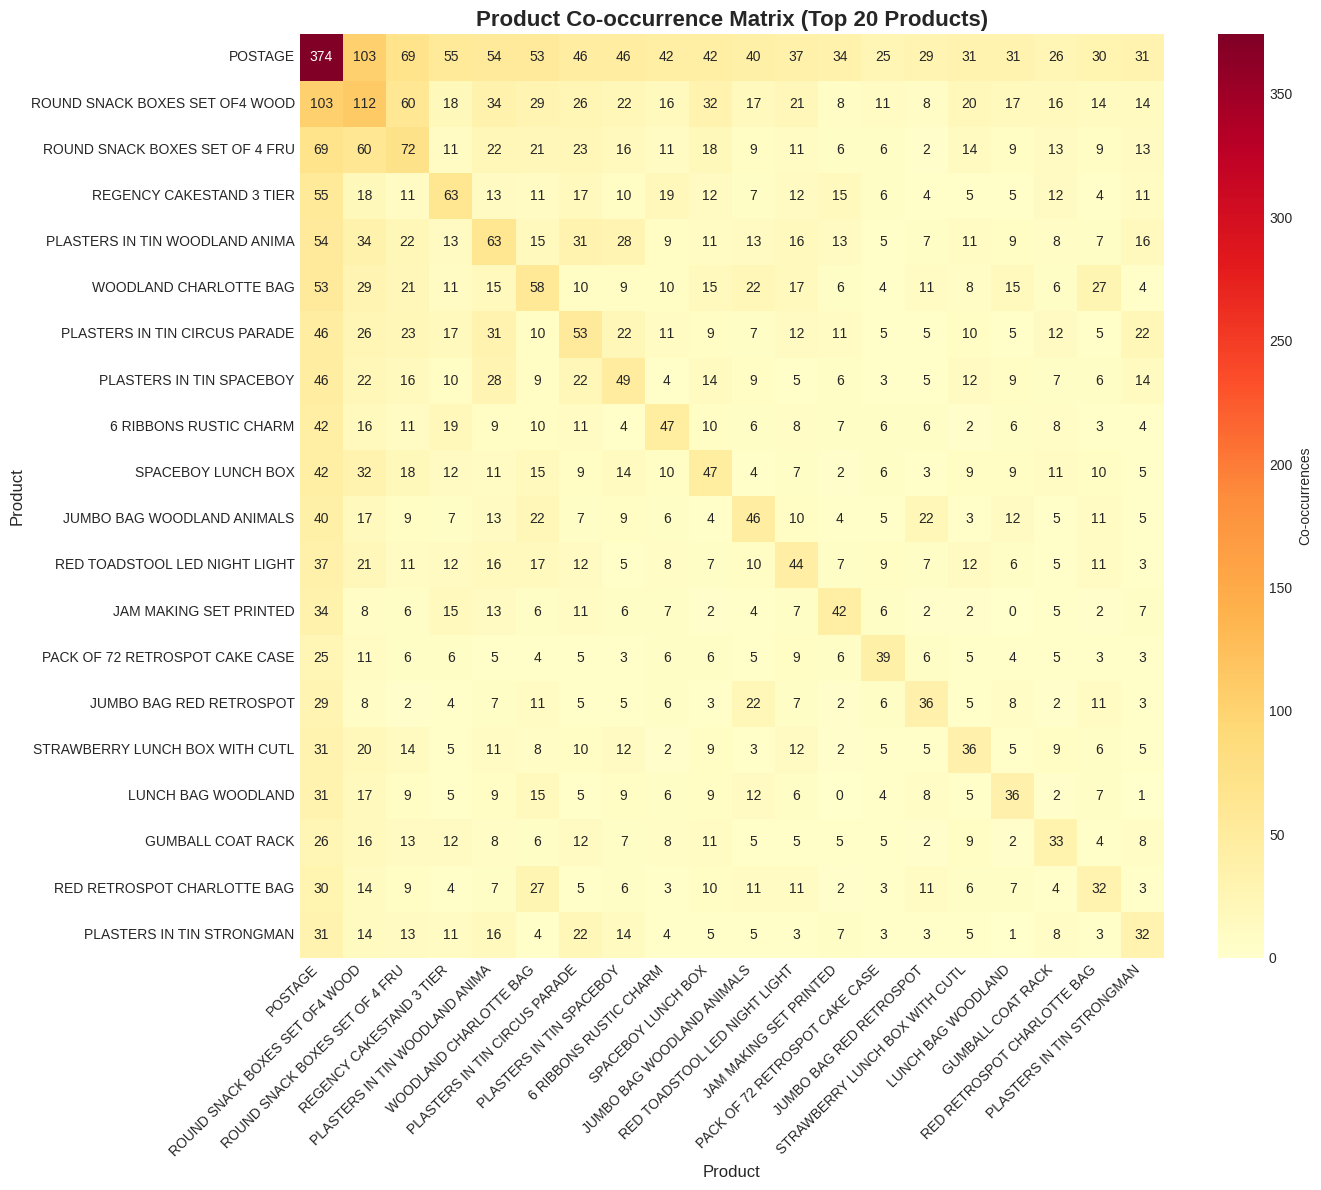

Co-occurrence matrix shows how often products appear together in transactions


In [21]:
# 4. Item Co-occurrence Matrix (Top Products)
if 'Description' in df_clean.columns:
    # Get top 20 products
    top_products_list = df_clean['Description'].value_counts().head(20).index.tolist()

    # Create co-occurrence matrix
    cooccurrence_matrix = np.zeros((len(top_products_list), len(top_products_list)))

    for transaction in transactions:
        transaction_set = set(transaction)
        for i, product1 in enumerate(top_products_list):
            for j, product2 in enumerate(top_products_list):
                if product1 in transaction_set and product2 in transaction_set:
                    cooccurrence_matrix[i, j] += 1

    # Create heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(cooccurrence_matrix,
                xticklabels=[p[:30] for p in top_products_list],  # Truncate long names
                yticklabels=[p[:30] for p in top_products_list],
                annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Co-occurrences'})
    plt.title('Product Co-occurrence Matrix (Top 20 Products)', fontsize=16, fontweight='bold')
    plt.xlabel('Product', fontsize=12)
    plt.ylabel('Product', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("Co-occurrence matrix shows how often products appear together in transactions")

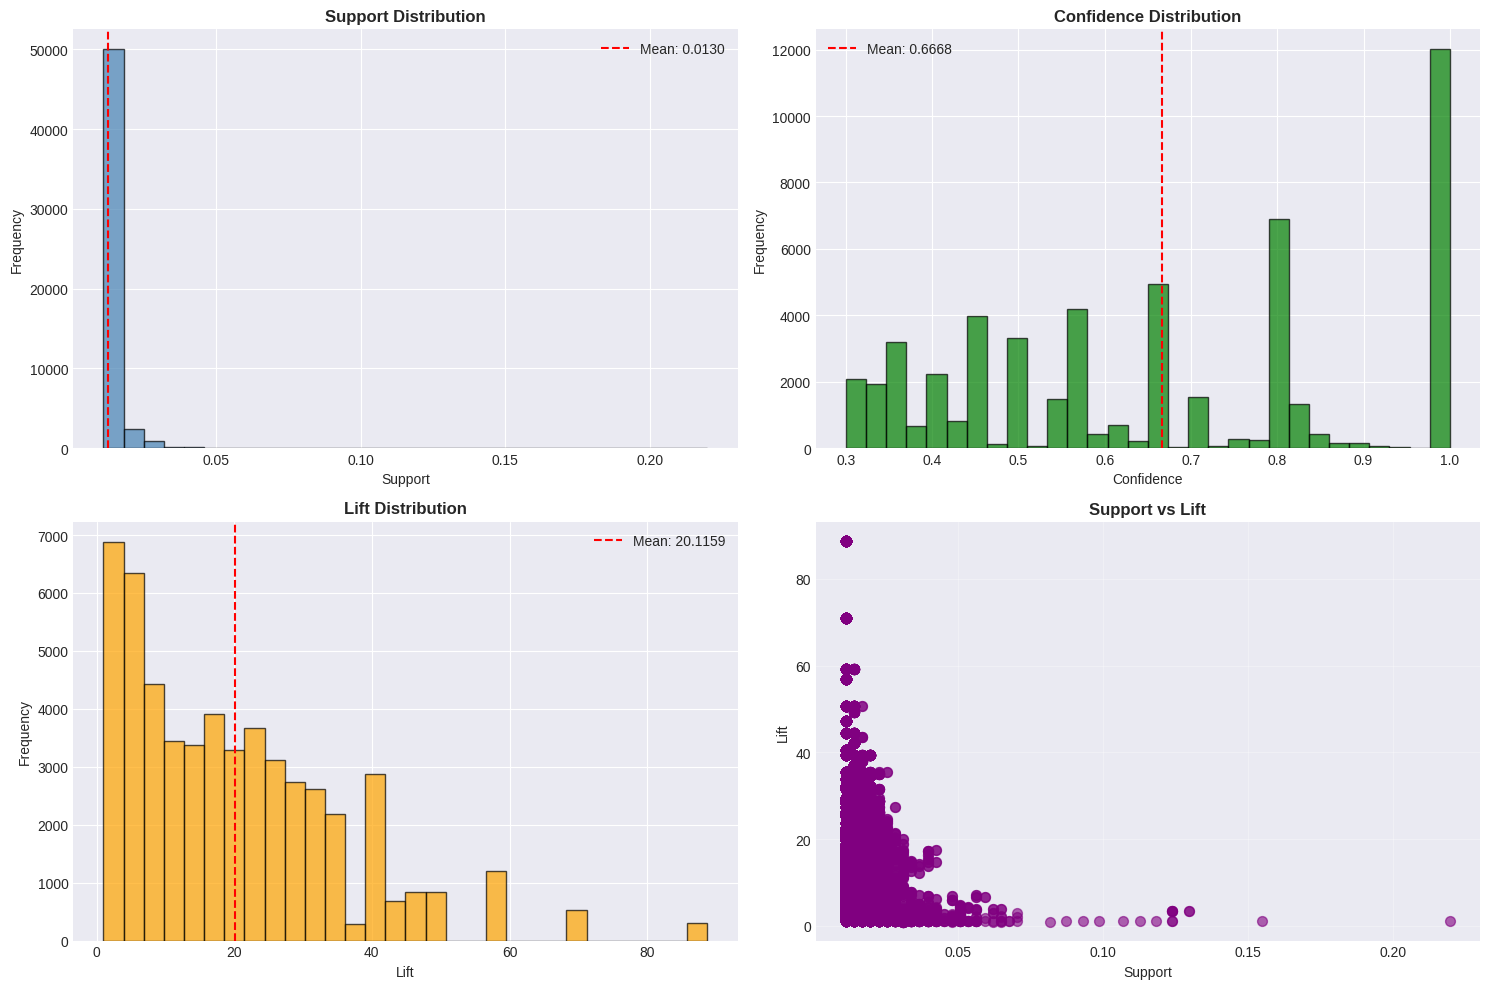

In [22]:
# 5. Rule Metrics Distribution
if len(business_rules) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Support distribution
    axes[0, 0].hist(business_rules['support'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].set_title('Support Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Support', fontsize=10)
    axes[0, 0].set_ylabel('Frequency', fontsize=10)
    axes[0, 0].axvline(business_rules['support'].mean(), color='red', linestyle='--',
                       label=f'Mean: {business_rules["support"].mean():.4f}')
    axes[0, 0].legend()

    # Confidence distribution
    axes[0, 1].hist(business_rules['confidence'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].set_title('Confidence Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Confidence', fontsize=10)
    axes[0, 1].set_ylabel('Frequency', fontsize=10)
    axes[0, 1].axvline(business_rules['confidence'].mean(), color='red', linestyle='--',
                      label=f'Mean: {business_rules["confidence"].mean():.4f}')
    axes[0, 1].legend()

    # Lift distribution
    axes[1, 0].hist(business_rules['lift'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 0].set_title('Lift Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Lift', fontsize=10)
    axes[1, 0].set_ylabel('Frequency', fontsize=10)
    axes[1, 0].axvline(business_rules['lift'].mean(), color='red', linestyle='--',
                      label=f'Mean: {business_rules["lift"].mean():.4f}')
    axes[1, 0].legend()

    # Support vs Lift
    axes[1, 1].scatter(business_rules['support'], business_rules['lift'],
                      alpha=0.6, color='purple', s=50)
    axes[1, 1].set_title('Support vs Lift', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Support', fontsize=10)
    axes[1, 1].set_ylabel('Lift', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 9. Summary and Insights

Key findings and actionable insights from the analysis.

In [25]:
# Summary statistics
print("="*80)
print("MARKET BASKET ANALYSIS SUMMARY")
print("="*80)

print(f"\n📊 Dataset Statistics:")
print(f"  - Total transactions (after cleaning): {len(transactions):,}")
print(f"  - Unique products: {len(te.columns_):,}")
print(f"  - Training transactions: {len(train_transactions):,}")
print(f"  - Test transactions: {len(test_transactions):,}")

print(f"\n🔍 Association Rules:")
print(f"  - Total frequent itemsets: {len(frequent_itemsets):,}")
print(f"  - Total association rules: {len(rules):,}")
print(f"  - Business-focused rules (lift>1, conf>=0.5, sup>=0.01): {len(business_rules):,}")

if len(business_rules) > 0:
    print(f"\n📈 Top Rule Metrics:")
    top_rule = business_rules.iloc[0]
    print(f"  - Highest Lift: {top_rule['lift']:.4f}")
    print(f"  - Highest Confidence: {business_rules['confidence'].max():.4f}")
    print(f"  - Highest Support: {business_rules['support'].max():.4f}")

    print(f"\n💡 Top 5 Business Rules:")
    for i, (idx, row) in enumerate(business_rules.head(5).iterrows(), 1):
        antecedents = ', '.join(list(row['antecedents']))
        consequents = ', '.join(list(row['consequents']))
        print(f"\n  {i}. {antecedents} → {consequents}")
        print(f"     Support: {row['support']:.4f} | Confidence: {row['confidence']:.4f} | Lift: {row['lift']:.4f}")

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)

MARKET BASKET ANALYSIS SUMMARY

📊 Dataset Statistics:
  - Total transactions (after cleaning): 444
  - Unique products: 255
  - Training transactions: 355
  - Test transactions: 89

🔍 Association Rules:
  - Total frequent itemsets: 8,261
  - Total association rules: 53,554
  - Business-focused rules (lift>1, conf>=0.5, sup>=0.01): 53,554

📈 Top Rule Metrics:
  - Highest Lift: 88.7500
  - Highest Confidence: 1.0000
  - Highest Support: 0.2197

💡 Top 5 Business Rules:

  1. RED HARMONICA IN BOX, 6 RIBBONS RUSTIC CHARM, REGENCY CAKESTAND 3 TIER → ROUND SNACK BOXES SET OF4 WOODLAND, SPACEBOY LUNCH BOX, GUMBALL COAT RACK
     Support: 0.0113 | Confidence: 1.0000 | Lift: 88.7500

  2. ROUND SNACK BOXES SET OF4 WOODLAND, SPACEBOY LUNCH BOX, GUMBALL COAT RACK → RED HARMONICA IN BOX, 6 RIBBONS RUSTIC CHARM, REGENCY CAKESTAND 3 TIER
     Support: 0.0113 | Confidence: 1.0000 | Lift: 88.7500

  3. RED HARMONICA IN BOX, 6 RIBBONS RUSTIC CHARM, POSTAGE, REGENCY CAKESTAND 3 TIER → ROUND SNACK BOXES S

In [26]:
# Export results to CSV for further analysis
if len(business_rules) > 0:
    # Format rules for export
    export_rules = business_rules.copy()
    export_rules['antecedents'] = export_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    export_rules['consequents'] = export_rules['consequents'].apply(lambda x: ', '.join(list(x)))

    # Save to CSV
    export_rules.to_csv('association_rules.csv', index=False)
    print("✅ Association rules exported to 'association_rules.csv'")

    # Save frequent itemsets
    frequent_itemsets_export = frequent_itemsets.copy()
    frequent_itemsets_export['itemsets'] = frequent_itemsets_export['itemsets'].apply(lambda x: ', '.join(list(x)))
    frequent_itemsets_export.to_csv('frequent_itemsets.csv', index=False)
    print("✅ Frequent itemsets exported to 'frequent_itemsets.csv'")

✅ Association rules exported to 'association_rules.csv'
✅ Frequent itemsets exported to 'frequent_itemsets.csv'
